# Data Mining Workflow

## Set Up the R Notebook for Analysis

In [1]:
# Load necessary packages
library('swat')
options(cas.print.messages = FALSE)
library('ggplot2')
library('reshape2')

# Data name
indata <- 'hmeq'

# Hostname, port, username, password
conn <- CAS('cdhnn.aft.sas.com', 5570, 'aftadmin', 'Orion123')

# Read in the dataset
castbl <- cas.read.csv(conn, 'http://support.sas.com/documentation/onlinedoc/viya/exampledatasets/hmeq.csv')

SWAT 1.0.0
NOTE: Connecting to CAS and generating CAS action functions for loaded
      action sets...
NOTE: To generate the functions with signatures (for tab completion), set 
      options(cas.gen.function.sig=TRUE).


## View Data

In [2]:
# Print the first few rows
head(castbl)

BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.36667,1,9,NaN
1,1300,70053,68400,HomeImp,Other,7.0,0,2,121.83333,0,14,NaN
1,1500,13500,16700,HomeImp,Other,4.0,0,0,149.46667,1,10,NaN
1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1700,97800,112000,HomeImp,Office,3.0,0,0,93.33333,0,14,NaN
1,1700,30548,40320,HomeImp,Other,9.0,0,0,101.46600,1,8,37.11361


## Get Summary Statistics

In [3]:
# Use summary function to get variable summary
summary(castbl)

      BAD              LOAN          MORTDUE               
 Min.   :0.0000   Min.   : 1100   Min.   :2063             
 1st Qu.:0.0000   1st Qu.:11100   1st Qu.:46268            
 Median :0.0000   Median :16300   Median :65019            
 Mean   :0.1995   Mean   :18608   Mean   :73760.817199559  
 3rd Qu.:0.0000   3rd Qu.:23300   3rd Qu.:91491            
 Max.   :1.0000   Max.   :89900   Max.   :399550           
                                  NA's   :518              
     VALUE                     REASON          JOB      
 Min.   :8000              DebtCon:3928   Mgr    : 767  
 1st Qu.:66069             HomeImp:1780   Office : 948  
 Median :89235.5           NA's   : 252   Other  :2388  
 Mean   :101776.04874145                  ProfExe:1276  
 3rd Qu.:119831.5                         Sales  : 109  
 Max.   :855909                           Self   : 193  
 NA's   :112                              NA's   : 279  
      YOJ                      DEROG                  
 Min.   :

## Visualize Numeric Variables

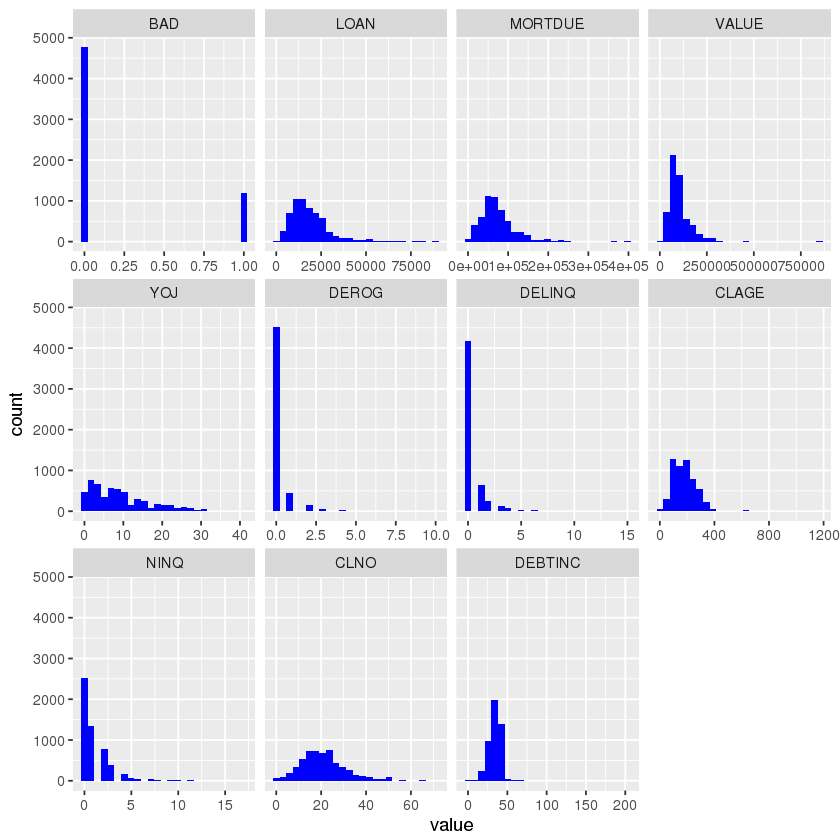

In [4]:
# Bring data locally
df <- to.casDataFrame(castbl, obs = nrow(castbl))

# Use reshape2's melt to help with data formatting
d <- melt(df[sapply(df, is.numeric)], id.vars=NULL)
plt <- ggplot(d, aes(x = value)) + 
          facet_wrap(~variable,scales = 'free_x') + 
          geom_histogram(fill = 'blue', bins = 25) 
suppressWarnings(print(plt))

## Check for Missingness

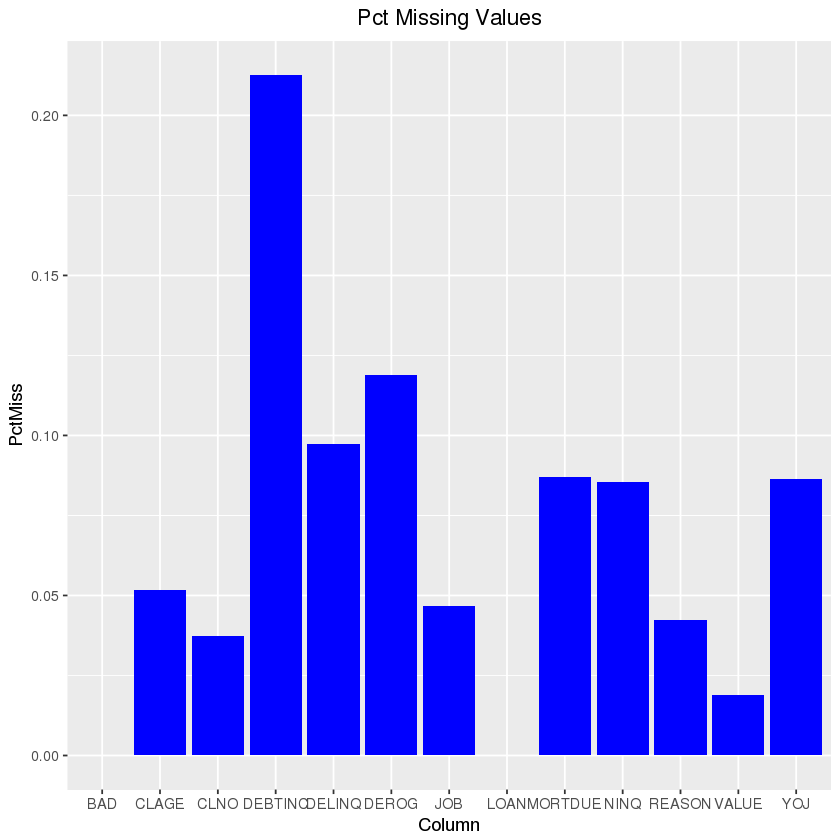

In [5]:
tbl <- cas.simple.distinct(castbl)$Distinct[,c('Column', 'NMiss')]
tbl$PctMiss <- tbl$NMiss/nrow(castbl)
ggplot(tbl, aes(Column, PctMiss)) + geom_col(fill = 'blue') + ggtitle('Pct Missing Values') + theme(plot.title = element_text(hjust = 0.5))

## Impute Missing Values

In [6]:
# Impute missing values, median for continuous variables, most frequent for nominal
cas.dataPreprocess.impute(castbl,
    methodContinuous = 'MEDIAN',
    methodNominal    = 'MODE',
    inputs           = colnames(castbl)[-1],
    copyAllVars      = TRUE,
    casOut           = list(name = indata, replace = TRUE)
)

Variable,ImputeTech,ResultVar,N,NMiss,ImputedValueContinuous,ImputedValueNominal
LOAN,Median,IMP_LOAN,5960,0,16300.00000,
MORTDUE,Median,IMP_MORTDUE,5442,518,65019.00000,
VALUE,Median,IMP_VALUE,5848,112,89235.50000,
REASON,Mode,IMP_REASON,5708,252,NaN,DebtCon
JOB,Mode,IMP_JOB,5681,279,NaN,Other
YOJ,Median,IMP_YOJ,5445,515,7.00000,
DEROG,Median,IMP_DEROG,5252,708,0.00000,
DELINQ,Median,IMP_DELINQ,5380,580,0.00000,
CLAGE,Median,IMP_CLAGE,5652,308,173.46667,
NINQ,Median,IMP_NINQ,5450,510,1.00000,


## Split the Data into Training and Validation

In [7]:
# Load the sampling actionset
loadActionSet(conn, 'sampling')

# Partition the data
samp <- cas.sampling.srs(conn,
    table   = indata,
    samppct = 30,
    partind = TRUE,
    output  = list(casOut = list(name = indata, replace = T), copyVars = 'ALL')
)

# Load the fedsql actionset
loadActionSet(conn, 'fedsql')

# Make sure the partition worked correctly using SQL
cas.fedsql.execDirect(conn, query = paste0("
    SELECT 
        CASE WHEN _PartInd_ = 0 THEN 'Training' ELSE 'Validation' END AS name,
        _PartInd_, 
        COUNT(*) AS obs 
    FROM ", indata, "
    GROUP BY 
        CASE WHEN _PartInd_ = 0 THEN 'Training' ELSE 'Validation' END,
        _PartInd_;
"))$`Result Set`

NAME,_PartInd_,OBS
Training,0,4172
Validation,1,1788


## Variable Shortcuts

In [8]:
# Get variable info and types
colinfo <- head(cas.table.columnInfo(conn, table = indata)$ColumnInfo, -1)

# My target variable is the first column
target <- colinfo$Column[1]

# For models that can inherently handle missing values (ex: Decision Tree)
inputs <- colinfo$Column[-1]
nominals <- c(target, subset(colinfo, Type == 'varchar')$Column)

# For models that cannot handle missing values (ex: Neural Network)
imp.inputs <- grep('IMP_', inputs, value = T)
imp.nominals <- c(target, grep('IMP_', nominals, value = T))

# Model Building

## Decision Tree

In [9]:
# Load the decsion tree actionset
loadActionSet(conn, 'decisionTree')

# Train the decision tree model
cas.decisionTree.dtreeTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    varImp   = TRUE,
    casOut   = list(name = 'dt_model', replace = TRUE)
)

Descr,Value
Number of Tree Nodes,15.0000
Max Number of Branches,2.0000
Number of Levels,6.0000
Number of Leaves,8.0000
Number of Bins,20.0000
Minimum Size of Leaves,5.0000
Maximum Size of Leaves,3191.0000
Number of Variables,24.0000
Confidence Level for Pruning,0.2500
Number of Observations Used,4172.0000


## Random Forest

In [10]:
# Train the random forest model
cas.decisionTree.forestTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    casOut   = list(name = 'rf_model', replace = TRUE)
)

Descr,Value
Number of Trees,50.00000
Number of Selected Variables (M),5.00000
Random Number Seed,0.00000
Bootstrap Percentage (%),63.21206
Number of Bins,20.00000
Number of Variables,24.00000
Confidence Level for Pruning,0.25000
Max Number of Tree Nodes,29.00000
Min Number of Tree Nodes,11.00000
Max Number of Branches,2.00000


## Gradient Boosting

In [11]:
cas.decisionTree.gbtreeTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    casOut   = list(name = 'gbt_model', replace = TRUE)
)

Descr,Value
Number of Trees,50.0
Distribution,2.0
Learning Rate,0.1
Subsampling Rate,0.5
Number of Selected Variables (M),24.0
Number of Bins,20.0
Number of Variables,24.0
Max Number of Tree Nodes,61.0
Min Number of Tree Nodes,27.0
Max Number of Branches,2.0


## Neural Network

In [12]:
# Load the neuralNet actionset
loadActionSet(conn, 'neuralNet')

# Build a neural network model
cas.neuralNet.annTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    target   = target, 
    inputs   = imp.inputs, 
    nominals = imp.nominals,
    casOut   = list(name = 'nn_model', replace = TRUE)
)

Progress,Objective,Loss
1,3.459671,3.459671
2,2.242000,2.242000
3,1.804584,1.804584
4,1.674074,1.674074
5,1.635367,1.635367
6,1.611151,1.611151
7,1.597205,1.597205
8,1.592238,1.592238
9,1.590793,1.590793
10,1.590193,1.590193


## Score the Models

In [13]:
# Score the models
models <- c('dt','rf','gbt','nn')
scores <- c(cas.decisionTree.dtreeScore, cas.decisionTree.forestScore, cas.decisionTree.gbtreeScore, cas.neuralNet.annScore)
names(scores) <- models

# Function to help automate prediction process on new data
score.params <- function(model){return(list(
    object       = defCasTable(conn, indata),
    modelTable   = list(name = paste0(model, '_model')),
    copyVars     = list(target, '_PartInd_'),
    assessonerow = TRUE,
    casOut       = list(name = paste0(model, '_scored'), replace = T)
))}
lapply(models, function(x) {do.call(scores[[x]], score.params(x))})

[[1]]
[[1]]$OutputCasTables
                 casLib      Name Rows Columns
1 CASUSERHDFS(aftadmin) dt_scored 5960      16

[[1]]$ScoreInfo
                        Descr                            Value
1 Number of Observations Read                             5960
2 Number of Observations Used                             5960
3 Misclassification Error (%)                      13.89261745


[[2]]
[[2]]$OutputCasTables
                 casLib      Name Rows Columns
1 CASUSERHDFS(aftadmin) rf_scored 5960       9

[[2]]$ScoreInfo
                        Descr                            Value
1 Number of Observations Read                             5960
2 Number of Observations Used                             5960
3 Misclassification Error (%)                      16.39261745


[[3]]
[[3]]$OutputCasTables
                 casLib       Name Rows Columns
1 CASUSERHDFS(aftadmin) gbt_scored 5960       8

[[3]]$ScoreInfo
                        Descr                            Value
1 Number of Observations Read                             5960
2 Number of Observations Used                             5960
3 Misclassification Error (%)                      7.533557047

[[3]]$ErrorMetricInfo
   TreeID Trees NLeaves        MCR   LogLoss        ASE      RASE     MAXAE
1       0     1      23 0.19949664 0.4568730 0.14451588 0.3801524 0.8091095
2       1     2      42 0.19949664 0.4276161 0.13322105 0.3649946 0.8256640
3       2     3      66 0.19949664 0.4025852 0.12330412 0.3511469 0.8356317
4       3     4      86 0.19832215 0.3852015 0.11629375 0.3410187 0.8460686
5       4     5     110 0.16577181 0.3695065 0.10991814 0.3315390 0.8559221
6       5     6     136 0.14412752 0.3563138 0.10484652 0.3238001 0.8658099
7       6     7     164 0.13489933 0.3424705 0.09977051 0.3158647 0.8757982
8       7     8     193 0.12114094 0.3318906 0.09587650 0.3096393 0.8839131
9       8     9     223 0.11493289 0.3212331 0.09211543 0.3035052 0.8935898
10      9    10     251 0.11006711 0.3125314 0.08917589 0.2986233 0.9022441
11     10    11     278 0.10738255 0.3047188 0.08656594 0.2942209 0.9097088
12     11    12     307 0.10402685 0.2986650 0.08458952 0.2908428 0.9162603
13     12    13     334 0.10201342 0.2924700 0.08259743 0.2873977 0.9226913
14     13    14     362 0.10151007 0.2874604 0.08108910 0.2847615 0.9280057
15     14    15     389 0.09949664 0.2822208 0.07953054 0.2820116 0.9324122
16     15    16     417 0.09932886 0.2769356 0.07806594 0.2794028 0.9373940
17     16    17     446 0.09731544 0.2727715 0.07681278 0.2771512 0.9406107
18     17    18     471 0.09731544 0.2686760 0.07569701 0.2751309 0.9453444
19     18    19     498 0.09463087 0.2643622 0.07450506 0.2729562 0.9490263
20     19    20     524 0.09412752 0.2618996 0.07387641 0.2718021 0.9523529
21     20    21     551 0.09312081 0.2582032 0.07290971 0.2700180 0.9553145
22     21    22     582 0.09177852 0.2541720 0.07169020 0.2677503 0.9596617
23     22    23     606 0.09177852 0.2521162 0.07120996 0.2668520 0.9606967
24     23    24     636 0.09177852 0.2484890 0.07025928 0.2650647 0.9639055
25     24    25     665 0.09060403 0.2445567 0.06919425 0.2630480 0.9655627
26     25    26     690 0.09010067 0.2420687 0.06846945 0.2616667 0.9670435
27     26    27     714 0.08926174 0.2398452 0.06794986 0.2606719 0.9699354
28     27    28     744 0.08859060 0.2373551 0.06732923 0.2594788 0.9714192
29     28    29     769 0.08825503 0.2350365 0.06675550 0.2583709 0.9737877
30     29    30     795 0.08691275 0.2324051 0.06597400 0.2568540 0.9742177
31     30    31     821 0.08624161 0.2296798 0.06516895 0.2552821 0.9749999
32     31    32     847 0.08506711 0.2266803 0.06441949 0.2538100 0.9734274
33     32    33     871 0.08456376 0.2244356 0.06373883 0.2524655 0.9747094
34     33    34     892 0.08456376 0.2225279 0.06329262 0.2515803 0.9770793
35     34    35     913 0.08406040 0.2209636 0.06286084 0.2507206 0.9778388
36     35    36     938 0.08389262 0.2191994 0.06237818 0.2497

## Compare Confusion Matrix

In [14]:
# Load the percentile actionset for scoring
loadActionSet(conn, 'percentile')

# Useful function for model assessment
assess.model <- function(model){
    cas.percentile.assess(conn,
        table    = list(name = paste0(model,'_scored'), where = '_PartInd_ = 1'),
        inputs   = paste0('_', model, '_P_           1'),
        response = target,
        event    = '1')
}

model.names <- c('Decision Tree', 'Random Forest', 'Gradient Boosting', 'Neural Network')
roc.df <- data.frame()
for (i in 1:length(models)){
    tmp <- (assess.model(models[i]))$ROCInfo
    tmp$Model <- model.names[i] 
    roc.df <- rbind(roc.df, tmp)
}

# Manipulate the dataframe
compare <- roc.df[round(roc.df$CutOff, 2) == 0.5,]
rownames(compare) <- NULL
compare[,c('Model','TP','FP','FN','TN')]

Model,TP,FP,FN,TN
Decision Tree,234,156,95,1303
Random Forest,44,0,285,1459
Gradient Boosting,224,59,105,1400
Neural Network,98,34,231,1425


## Compare Misclassification

In [15]:
# Build a dataframe to compare the misclassification rates
compare$Misclassification <- 1 - compare$ACC
miss <- compare[order(compare$Misclassification), c('Model','Misclassification')]
rownames(miss) <- NULL
miss

Model,Misclassification
Gradient Boosting,0.0917226
Decision Tree,0.1403803
Neural Network,0.1482103
Random Forest,0.1593960


## Compare ROC Curves

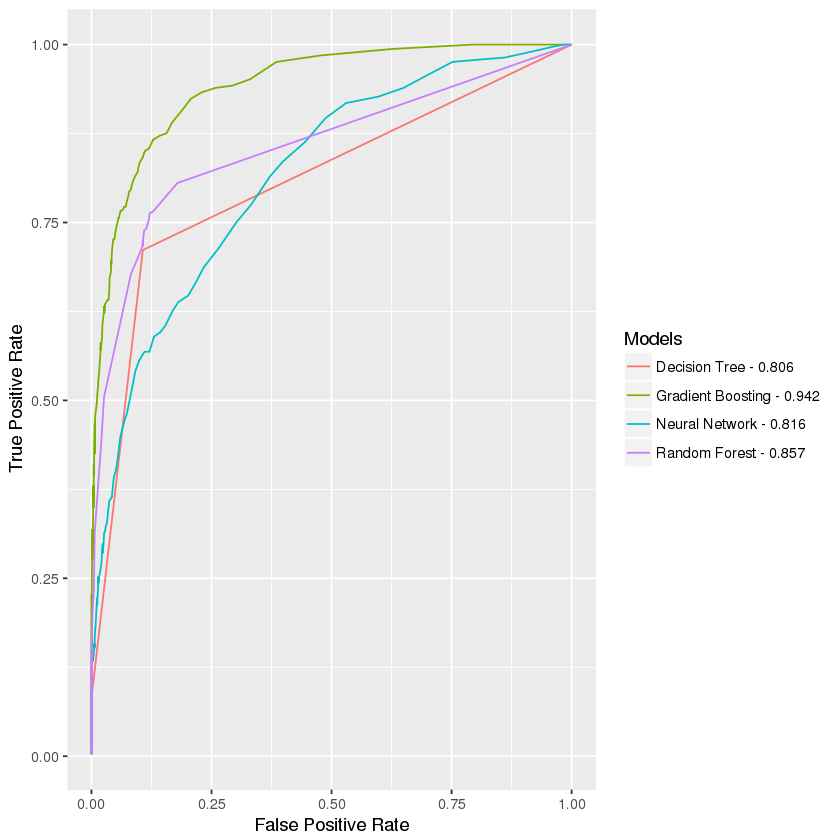

In [16]:
# Add a new column to be used as the ROC curve label
roc.df$Models <- paste(roc.df$Model, round(roc.df$C, 3), sep = ' - ')

# Create the ROC curve
ggplot(data = roc.df[c('FPR', 'Sensitivity', 'Models')], 
       aes(x = as.numeric(FPR), y = as.numeric(Sensitivity), colour = Models)) + geom_line() +
       labs(x = 'False Positive Rate', y = 'True Positive Rate')

## Save the CAS Gradient Boosting Model

In [17]:
# Save the champion model for later use
cas.table.save(conn, table = list(name = 'gbt_model'), name = 'gbt_model', replace = T)

$caslib
[1] "CASUSERHDFS(aftadmin)"

$name
[1] "gbt_model.sashdat"

## End the Session

In [18]:
# End the session
cas.session.endSession(conn)

list()